# ML notebook 

## 1. Setup

In [ ]:
# !pip install pandas numpy==1.24.0 matplotlib seaborn scikit-learn nltk FuzzyTM blosc2 cython langchain==0.3.8 langsmith==0.1.125

In [9]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('data/song_dataset.csv')

# Display the first few rows
data.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


### Preprocessing

#### Check for missing values

In [ ]:
# Check for missing values
print(data.isnull().sum())

data = data.dropna(subset=['genre', 'len', 'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy'])

#### Encoding Categorical Variables

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode 'genre' if needed
le_genre = LabelEncoder()
data['genre_encoded'] = le_genre.fit_transform(data['genre'])

#### Feature Scaling

In [29]:
from sklearn.preprocessing import StandardScaler

numerical_features = [
    # Audio features (current)
    'len', 'danceability', 'loudness', 'acousticness', 
    'instrumentalness', 'valence', 'energy',
    # Lyrical/thematic features
    'dating', 'violence', 'world/life', 'romantic', 
    'sadness', 'feelings'
]

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


## 2. Song Similarity Model

#### Feature Selection

In [30]:
# Define features and target
features = numerical_features + ['genre_encoded']


# Create feature matrix X
X = data[features].values


In [34]:
from sklearn.neighbors import NearestNeighbors

# Initialize the model
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')

# Fit the model
knn_model.fit(X)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

#### Recommendation System using KNN

In [35]:
def recommend_songs(song_title, data, model, n_recommendations=5):
    # Find the index of the song in the dataset
    idx = data[data['track_name'].str.lower() == song_title.lower()].index
    if idx.empty:
        print(f"Song '{song_title}' not found in the dataset.")
        return []
    idx = idx[0]
    
    # Get the feature vector for the song
    song_features = X[idx].reshape(1, -1)
    
    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features, n_neighbors=n_recommendations+1)
    
    # Prepare recommendations, skipping the first one (itself)
    recommendations = []
    for i in range(1, len(indices.flatten())):
        rec_idx = indices.flatten()[i]
        recommendations.append({
            'track_name': data.iloc[rec_idx]['track_name'],
            'artist_name': data.iloc[rec_idx]['artist_name'],
            'distance': distances.flatten()[i]
        })
    return recommendations

#### Test the song similarity recommendation model

In [36]:
def test_recommendation_system(data, model, num_tests=5):
    """Test the recommendation system with multiple songs and validation checks"""
    
    # 1. Test with random songs from dataset
    print("1. Testing with random songs from dataset:")
    random_songs = data['track_name'].sample(num_tests).tolist()
    
    for song in random_songs:
        print(f"\nTesting song: {song}")
        try:
            recommendations = recommend_songs(song, data, model)
            if recommendations:
                print("Recommendations:")
                for rec in recommendations:
                    print(f"- {rec['track_name']} by {rec['artist_name']}")
                    print(f"  Similarity: {1 - rec['distance']:.4f}")
                    
                # Validate recommendations
                print("\nValidation:")
                print(f"- Original genre: {data[data['track_name'] == song]['genre'].iloc[0]}")
                print(f"- Original artist: {data[data['track_name'] == song]['artist_name'].iloc[0]}")
                
        except Exception as e:
            print(f"Error processing {song}: {str(e)}")
    
    # 2. Test edge cases
    print("\n2. Testing edge cases:")
    edge_cases = [
        '',                    # Empty string
        'NonexistentSong',     # Non-existent song
        'FUTURE',              # All caps
        'future   ',           # Extra spaces
        song.lower(),          # Lowercase version
    ]
    
    for case in edge_cases:
        print(f"\nTesting edge case: '{case}'")
        try:
            recommendations = recommend_songs(case, data, model)
            if recommendations:
                print("Found recommendations!")
            else:
                print("No recommendations found")
        except Exception as e:
            print(f"Error: {str(e)}")
    
    # 3. Performance metrics
    print("\n3. Performance metrics:")
    import time
    start_time = time.time()
    _ = recommend_songs(random_songs[0], data, model)
    print(f"Single recommendation time: {(time.time() - start_time):.4f} seconds")

# Run the tests
test_recommendation_system(data, knn_model)

# You can still test specific songs
print("\nTesting specific song:")
song_title = 'future'
recommendations = recommend_songs(song_title, data, knn_model)
if recommendations:
    print(f"\nRecommendations for '{song_title}':")
    for rec in recommendations:
        print(f"- {rec['track_name']} by {rec['artist_name']}")
        print(f"  Similarity: {1 - rec['distance']:.4f}")
        print(f"  Genre: {data[data['track_name'] == rec['track_name']]['genre'].iloc[0]}")

1. Testing with random songs from dataset:

Testing song: (ghost) riders in the sky
Recommendations:
- no man can find the war by tim buckley
  Similarity: 0.9190
- rip rip woodchip by john williamson
  Similarity: 0.9181
- the last gunfighter ballad by johnny cash
  Similarity: 0.9117
- the devil's train by hank williams
  Similarity: 0.9107
- point of light by randy travis
  Similarity: 0.9082

Validation:
- Original genre: country
- Original artist: sons of the pioneers

Testing song: bad mutha fucka
Recommendations:
- salue by big scoob
  Similarity: 0.9680
- girls like that by krizz kaliko
  Similarity: 0.9580
- doubt me now by lil wyte
  Similarity: 0.9520
- blame it on da bay by lil wyte
  Similarity: 0.9515
- red nose by tech n9ne collabos
  Similarity: 0.9513

Validation:
- Original genre: country
- Original artist: upchurch

Testing song: holdin'
Recommendations:
- gateway love by thomas rhett
  Similarity: 0.9276
- left handed cigarettes by radioinactive
  Similarity: 0.9212

## 3. User-side Setup and Preference Generation

In [37]:
users_df = pd.read_csv('data/users.csv')
users_df.head()

,User_id,first_name,last_name,email,gender,Country,Password
0,12-685-2499,Bil,Anderton,banderton0@nytimes.com,Male,South Africa,$2a$04$tWNbKhVMvp/Akim.5SIqmuCb1ESsl9YCzs47xsi...
1,57-659-0167,Karlan,Till,ktill1@yellowbook.com,Male,Argentina,$2a$04$.b6q2fGZRrj8sMOF/b.OW.BbZAJFoXSKuPJPUPs...
2,41-168-0569,Filip,Bleyman,fbleyman2@google.com.br,Male,Turkmenistan,$2a$04$nwOY01zJELpe7UWRyqQEj.LdAHv8FypPkx/xEm5...
3,20-492-6176,Margalo,Maleney,mmaleney3@51.la,Female,Indonesia,$2a$04$p/mboYiJVX29IW.IB6H77OHPxjkgtPhEnUh5/rE...
4,70-494-3742,Neille,Mammatt,nmammatt4@biglobe.ne.jp,Female,Poland,$2a$04$DtRw5JWa3BeyRH0NKsn09ufhm0PjYKy0I1LPfSE...


### Generate User Preferences

In [38]:
def generate_initial_preferences(user_id, num_preferences=5):
    """Generate random initial song preferences for a new user"""
    # Randomly sample songs from our music dataset
    random_songs = data.sample(n=num_preferences)
    
    preferences = []
    for _, song in random_songs.iterrows():
        preferences.append({
            'user_id': user_id,
            'track_name': song['track_name'],
            'artist_name': song['artist_name'],
            'rating': np.random.randint(3, 6),  # Random rating 3-5 for initial preferences
            'timestamp': pd.Timestamp.now()  # Add timestamp for tracking
        })
    return preferences


In [40]:
# Generate preferences for all users
all_preferences = []
for user_id in users_df['User_id']:
    all_preferences.extend(generate_initial_preferences(user_id))

In [41]:
preferences_df = pd.DataFrame(all_preferences)

print("Sample of generated user preferences:")
print(preferences_df.head(10))

Sample of generated user preferences:
       user_id                       track_name          artist_name  rating  \
0  12-685-2499          i'll sail my ship alone            ray price       5   
1  12-685-2499                 pearl's a singer         elkie brooks       4   
2  12-685-2499                     soul-crusher         white zombie       4   
3  12-685-2499  don't you throw that mojo on me           mark selby       4   
4  12-685-2499                   oil in my lamp            the byrds       5   
5  57-659-0167          senses working overtime                  xtc       3   
6  57-659-0167       the waltz you saved for me        john anderson       4   
7  57-659-0167             carefree country day  buffalo springfield       4   
8  57-659-0167                   heart of stone         chris knight       4   
9  57-659-0167             sinister footwear ii          frank zappa       3   

                   timestamp  
0 2024-12-05 14:25:22.650160  
1 2024-12-05 14:25:

In [42]:
# Save preferences to CSV (optional)
preferences_df.to_csv('data/user_preferences.csv', index=False)

### Test the recommendation system with user preferences

In [44]:
def get_user_recommendations(user_id, preferences_df, data, model, n_recommendations=5):
    """Get recommendations for a user based on their preferences"""
    # Get user's existing preferences
    user_prefs = preferences_df[preferences_df['user_id'] == user_id]
    
    if user_prefs.empty:
        print(f"No preferences found for user {user_id}")
        return []
    
    # Get recommendations based on each preferred song
    all_recommendations = []
    for _, pref in user_prefs.iterrows():
        recs = recommend_songs(pref['track_name'], data, model)
        all_recommendations.extend(recs)
    
    # Remove duplicates and sort by similarity
    seen = set()
    unique_recommendations = []
    for rec in all_recommendations:
        if rec['track_name'] not in seen:
            seen.add(rec['track_name'])
            unique_recommendations.append(rec)
    
    # Sort by similarity and return top N
    return sorted(unique_recommendations, key=lambda x: x['distance'])[:n_recommendations]

# Test for a specific user
test_user_id = users_df['User_id'].iloc[0]
print(f"\nRecommendations for user {test_user_id}:")
user_recs = get_user_recommendations(test_user_id, preferences_df, data, knn_model, 10)
for rec in user_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Similarity: {1 - rec['distance']:.4f})")


Recommendations for user 12-685-2499:
- ramblin' boy by tom paxton (Similarity: 0.9833)
- they call the wind maria by sam cooke (Similarity: 0.9817)
- do you hear what i hear? by andy williams (Similarity: 0.9801)
- blue skies by bobby darin (Similarity: 0.9756)
- voices in the sky by the moody blues (Similarity: 0.9748)
- pictures by the statler brothers (Similarity: 0.9742)
- roll right by rage against the machine (Similarity: 0.9727)
- the righteous & the wicked by red hot chili peppers (Similarity: 0.9717)
- year of tha boomerang by rage against the machine (Similarity: 0.9700)
- all hell's breakin' loose by kiss (Similarity: 0.9673)


### More realistic tests through Listening History dataset

In [47]:
# First, add age groups and preferred genres to users
users_df['AgeGroup'] = np.random.choice(['Under 18', '18-24', '25-34', '35-44', '45+'], size=len(users_df))

def assign_preferred_genre(age_group):
    age_genre_map = {
        'Under 18': ['pop', 'hip hop', 'electronic'],
        '18-24': ['pop', 'hip hop', 'electronic', 'alternative'],
        '25-34': ['rock', 'pop', 'alternative', 'country'],
        '35-44': ['rock', 'country', 'jazz', 'blues'],
        '45+': ['classical', 'jazz', 'blues', 'country']
    }
    return np.random.choice(age_genre_map.get(age_group, data['genre'].unique()))

users_df['PreferredGenre'] = users_df['AgeGroup'].apply(assign_preferred_genre)


#### Generate Listening History

In [48]:
listening_history = []

for _, user in users_df.iterrows():
    user_id = user['User_id']
    preferred_genre = user['PreferredGenre']
    num_songs = np.random.randint(50, 200)
    
    # Select songs from preferred genre (with fallback)
    preferred_songs = data[data['genre'] == preferred_genre]
    if len(preferred_songs) == 0:  # If no songs found in preferred genre
        preferred_genre = np.random.choice(data['genre'].unique())  # Pick a random genre
        preferred_songs = data[data['genre'] == preferred_genre]
    
    num_preferred_songs = min(int(num_songs * 0.8), len(preferred_songs))  # Ensure we don't exceed available songs
    num_other_songs = min(num_songs - num_preferred_songs, len(data) - len(preferred_songs))
    
    # Sample songs
    preferred_song_indices = preferred_songs.sample(n=num_preferred_songs, replace=True).index
    other_songs = data[data['genre'] != preferred_genre].sample(n=num_other_songs, replace=True).index
    
    song_indices = np.concatenate([preferred_song_indices, other_songs])
    np.random.shuffle(song_indices)
    
    for idx in song_indices:
        days_ago = np.random.randint(0, 30)
        listen_date = pd.Timestamp('today') - pd.Timedelta(days=days_ago)
        listening_history.append({
            'UserID': user_id,
            'SongID': data.iloc[idx]['track_name'],
            'ArtistName': data.iloc[idx]['artist_name'],
            'ListenDate': listen_date,
            'Rating': np.random.randint(1, 6)  # Ratings between 1 and 5
        })

# Create DataFrame
listening_history_df = pd.DataFrame(listening_history)
print("\nAvailable genres in dataset:", data['genre'].unique())
print("\nSample Listening History:")
print(listening_history_df.head())
print(f"\nTotal listening records generated: {len(listening_history_df)}")


Available genres in dataset: ['pop' 'country' 'blues' 'jazz' 'reggae' 'rock' 'hip hop']

Sample Listening History:
        UserID                             SongID    ArtistName  \
0  12-685-2499               the steamin' feelin'     bob james   
1  12-685-2499  they can’t take that away from me    josé james   
2  12-685-2499                            hey you  the pharcyde   
3  12-685-2499                       what'd i say   herbie mann   
4  12-685-2499              just give me a chance   peter white   

                  ListenDate  Rating  
0 2024-11-28 14:31:34.442612       1  
1 2024-11-26 14:31:34.442861       4  
2 2024-11-18 14:31:34.442991       3  
3 2024-11-06 14:31:34.443111       3  
4 2024-11-10 14:31:34.443225       5  

Total listening records generated: 125779


## 4. Collaborative Filtering Model

### Create user-song relation: interaction matrix

In [49]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
song_encoder = LabelEncoder()

listening_history_df['UserID_encoded'] = user_encoder.fit_transform(listening_history_df['UserID'])
listening_history_df['SongID_encoded'] = song_encoder.fit_transform(listening_history_df['SongID'])


In [50]:
# Pivot table with users as rows and songs as columns
user_item_matrix = listening_history_df.pivot_table(
    index='UserID_encoded', 
    columns='SongID_encoded', 
    values='Rating', 
    aggfunc='mean'  # Use mean rating if multiple entries
).fillna(0)


User-Item Matrix Shape: (1000, 23200)

Number of users: 1000
Number of songs: 23200

Sparsity: 0.00%

Sample of User-Item Matrix (5x5):
SongID_encoded    0    1    2    3    4
UserID_encoded                         
0               0.0  0.0  0.0  0.0  0.0
1               0.0  0.0  0.0  0.0  0.0
2               0.0  0.0  0.0  0.0  0.0
3               1.0  0.0  0.0  0.0  0.0
4               0.0  0.0  0.0  0.0  0.0


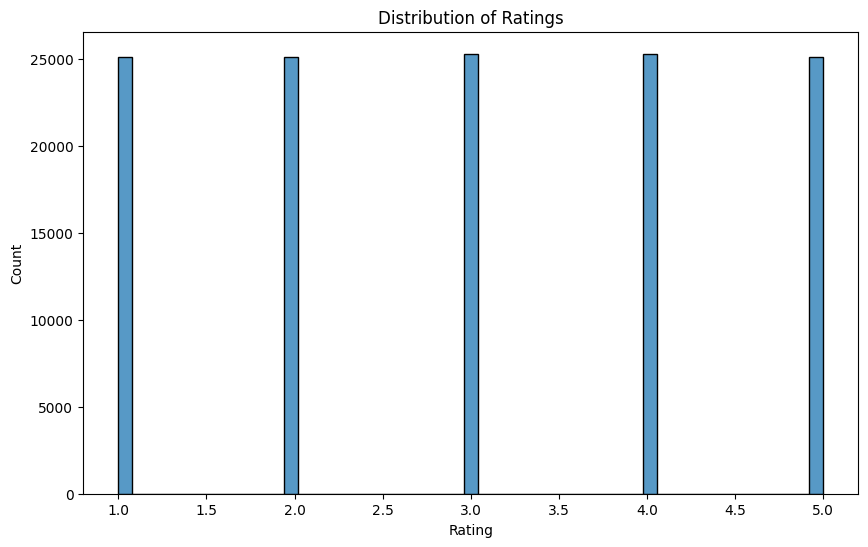

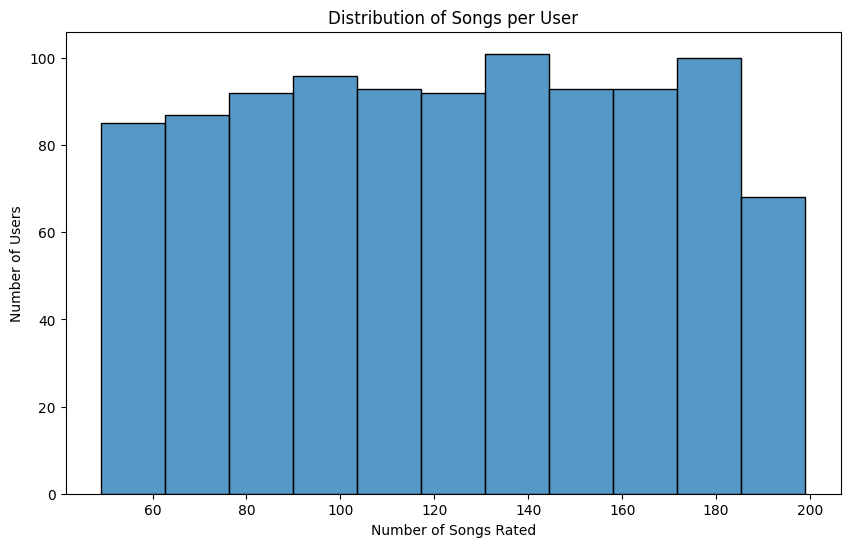


Sample of ID mappings:

User ID mapping:
  Original_UserID  Encoded_UserID
0     12-685-2499             120
1     57-659-0167             573
2     41-168-0569             405
3     20-492-6176             208
4     70-494-3742             697


In [51]:
# 1. Basic information about the matrix
print("User-Item Matrix Shape:", user_item_matrix.shape)
print("\nNumber of users:", len(user_item_matrix))
print("Number of songs:", len(user_item_matrix.columns))
print("\nSparsity: {:.2%}".format(user_item_matrix.isnull().sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])))

# 2. Sample of the matrix
print("\nSample of User-Item Matrix (5x5):")
print(user_item_matrix.iloc[:5, :5])

# 3. Rating distribution
import seaborn as sns
import matplotlib.pyplot as plt

# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(listening_history_df['Rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 4. User activity analysis
user_activity = user_item_matrix.astype(bool).sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(user_activity)
plt.title('Distribution of Songs per User')
plt.xlabel('Number of Songs Rated')
plt.ylabel('Number of Users')
plt.show()

# 5. Check mapping back to original IDs
print("\nSample of ID mappings:")
sample_users = pd.DataFrame({
    'Original_UserID': users_df['User_id'].iloc[:5],
    'Encoded_UserID': user_encoder.transform(users_df['User_id'].iloc[:5])
})
print("\nUser ID mapping:")
print(sample_users)

### Implementing a Collaborative Filtering Model

In [52]:
from sklearn.neighbors import NearestNeighbors

knn_user = NearestNeighbors(metric='cosine', algorithm='brute')
knn_user.fit(user_item_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

### Song to user recommendation

In [53]:
def recommend_songs_to_user(user_id, user_item_matrix, model, n_recommendations=5):
    # Encode user ID
    user_idx = user_encoder.transform([user_id])[0]
    
    # Get user vector
    user_vector = user_item_matrix.loc[user_idx].values.reshape(1, -1)
    
    # Find similar users
    distances, indices = model.kneighbors(user_vector, n_neighbors=6)
    similar_users = indices.flatten()[1:]  # Exclude the user themselves
    
    # Get songs from similar users
    similar_users_songs = listening_history_df[listening_history_df['UserID_encoded'].isin(similar_users)]
    user_songs = set(listening_history_df[listening_history_df['UserID_encoded'] == user_idx]['SongID_encoded'])
    
    # Recommend songs not listened by the user
    recommendations = similar_users_songs[~similar_users_songs['SongID_encoded'].isin(user_songs)]
    top_recommendations = recommendations.groupby('SongID_encoded').agg({'Rating': 'mean'}).sort_values('Rating', ascending=False).head(n_recommendations)
    
    # Decode song IDs
    recommended_song_ids = top_recommendations.index
    recommended_songs = song_encoder.inverse_transform(recommended_song_ids)
    
    # Prepare recommendations
    recommended_songs_list = []
    for song_id in recommended_songs:
        song_data = data[data['track_name'] == song_id].iloc[0]
        recommended_songs_list.append({
            'track_name': song_data['track_name'],
            'artist_name': song_data['artist_name'],
            'average_rating': top_recommendations.loc[song_encoder.transform([song_id])[0]]['Rating'],
            'genre': song_data['genre']
        })
    return recommended_songs_list


### Test the song to user recommendation system

In [54]:
# Example user
test_user_id = users_df['User_id'].iloc[0]
recommendations = recommend_songs_to_user(test_user_id, user_item_matrix, knn_user, n_recommendations=5)

print(f"Recommendations for User ID '{test_user_id}':")
for rec in recommendations:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Avg Rating: {rec['average_rating']:.2f}) Genre: {rec['genre']}")


Recommendations for User ID '12-685-2499':
- zing! went the strings of my heart by the coasters (Avg Rating: 5.00) Genre: blues
- non-stop home by weather report (Avg Rating: 5.00) Genre: jazz
- ova confident by nine (Avg Rating: 5.00) Genre: hip hop
- come closer by salma agha (Avg Rating: 5.00) Genre: pop
- coco by o.t. genasis (Avg Rating: 5.00) Genre: pop


### Summary

The parts above used 4 of the entities and 2 datasets and generated preferences :
- User: Contains user demographics and preferences.
- ListeningHistory: Records user interactions with songs.
- Song: Provides song metadata, including genre and artist.
- Genre: Connected via foreign keys, enabling genre-based analysis.
    


## 5. Mood-based Recommendation Model

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Ensure 'topic' is categorical
data['topic'] = data['topic'].astype(str)
topic_le = LabelEncoder()
data['topic_encoded'] = topic_le.fit_transform(data['topic'])

# Features (already defined)
mood_features = numerical_features + ['genre_encoded']  # Using the same features as before
X_mood = data[mood_features].values
y_mood = data['topic_encoded'].values

# Split into train and test
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mood, y_mood, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_clf.fit(X_train_m, y_train_m)

# Evaluate
y_pred_m = dt_clf.predict(X_test_m)
print("Mood Classification Report:")
print(classification_report(y_test_m, y_pred_m, target_names=topic_le.classes_))


Mood Classification Report:
              precision    recall  f1-score   support

    feelings       1.00      0.95      0.98       130
       music       0.47      0.47      0.47       494
  night/time       0.35      0.02      0.03       361
     obscene       0.65      0.85      0.74       997
    romantic       0.95      0.98      0.97       297
     sadness       0.98      1.00      0.99      1197
    violence       0.99      0.99      0.99      1155
  world/life       0.98      0.99      0.99      1044

    accuracy                           0.86      5675
   macro avg       0.80      0.78      0.77      5675
weighted avg       0.84      0.86      0.84      5675



In [56]:
def get_mood_recommendations(mood_label, data, dt_model, n_recommendations=10):
    # Convert mood_label (string) to encoded form if it exists
    if mood_label not in topic_le.classes_:
        print(f"Mood '{mood_label}' not recognized. Available moods: {list(topic_le.classes_)}")
        return []

    target_mood_encoded = topic_le.transform([mood_label])[0]

    # Predict mood for all songs
    all_songs_features = data[mood_features].values
    mood_preds = dt_model.predict(all_songs_features)
    
    # Filter songs that match the requested mood
    mood_songs = data[mood_preds == target_mood_encoded]

    # If you want to rank them by popularity or average rating from your user base, 
    # you can integrate ListeningHistory or StreamingMetrics data.
    # For now, we'll return a random sample of songs from this mood.
    if len(mood_songs) == 0:
        print(f"No songs found for mood '{mood_label}'")
        return []
    
    recommendations = mood_songs.sample(min(n_recommendations, len(mood_songs)))[['track_name', 'artist_name', 'genre', 'topic']]
    return recommendations.to_dict('records')


# Example: Get 5 "sadness" mood recommendations
sad_recs = get_mood_recommendations('sadness', data, dt_clf, n_recommendations=5)
print("\nSadness Mood Recommendations:")
for rec in sad_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Topic: {rec['topic']})")



Sadness Mood Recommendations:
- you sure got this ol' redneck feelin' blue by george strait (Genre: country, Topic: sadness)
- i can't help it (if i'm still in love with you) by marty robbins (Genre: country, Topic: sadness)
- thou shall not steal by wailing souls (Genre: reggae, Topic: sadness)
- i hang my head and cry by marty robbins (Genre: country, Topic: sadness)
- hip hop esta vivo by hata proof records presents mr nava (Genre: hip hop, Topic: sadness)


## 6. Time-based Recommendation Model

In [57]:
# Extract hour of day from ListenDate
listening_history_df['hour'] = listening_history_df['ListenDate'].dt.hour

# Group by hour and genre to find popular genres at different times
hour_genre_popularity = listening_history_df.groupby(['hour', 'ArtistName', 'SongID']).agg({'Rating': 'mean'}).reset_index()
# Could also group by hour and Genre if you have that mapping


In [59]:
# Top genres per hour
merged = listening_history_df.merge(data[['track_name', 'genre']], left_on='SongID', right_on='track_name', how='left')

hour_genre_rating = merged.groupby(['hour', 'genre']).agg({'Rating': 'mean'}).reset_index()

def time_of_day_recommendations(current_hour, data, listening_df, n_recommendations=5):
    # Find the top genre at this hour
    hour_data = hour_genre_rating[hour_genre_rating['hour'] == current_hour]
    if hour_data.empty:
        # Fallback: Just pick a random genre
        top_genre = np.random.choice(data['genre'].unique())
    else:
        top_genre = hour_data.sort_values('Rating', ascending=False)['genre'].iloc[0]

    # Recommend random songs from this top genre
    genre_songs = data[data['genre'] == top_genre]
    if len(genre_songs) == 0:
        return []

    recs = genre_songs.sample(min(n_recommendations, len(genre_songs)))[['track_name', 'artist_name', 'genre']]
    return recs.to_dict('records')




In [60]:
# Example test? Get time-of-day recommendations for 9 PM (21:00)
tod_recs = time_of_day_recommendations(21, data, listening_history_df, n_recommendations=5)
print("\nTime-of-Day Recommendations (21:00):")
for rec in tod_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']})")


Time-of-Day Recommendations (21:00):
- are you in? by incubus (Genre: pop)
- sleepyhead by passion pit (Genre: pop)
- money by michael jackson (Genre: pop)
- my beautiful rescue by this providence (Genre: pop)
- everything put together falls apart by paul simon (Genre: pop)


## 7. SVD Model for Collaborative Filtering

In [61]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T  # Items (songs) in factor space


### Generate recommendations

In [62]:
def svd_recommendations(user_id, user_item_matrix, user_factors, item_factors, n_recommendations=5):
    user_idx = user_encoder.transform([user_id])[0]
    user_vector = user_factors[user_idx]

    # Predict scores as dot product of user_vector and item_factors
    scores = np.dot(user_vector, item_factors.T)

    # Exclude already listened songs
    user_listened = set(listening_history_df[listening_history_df['UserID_encoded'] == user_idx]['SongID_encoded'])
    scores_filtered = [(i, s) for i, s in enumerate(scores) if i not in user_listened]

    # Sort by score and pick top
    top_items = sorted(scores_filtered, key=lambda x: x[1], reverse=True)[:n_recommendations]

    recommended_songs_list = []
    for item_idx, score in top_items:
        song_name = song_encoder.inverse_transform([item_idx])[0]
        row = data[data['track_name'] == song_name].iloc[0]
        recommended_songs_list.append({
            'track_name': row['track_name'],
            'artist_name': row['artist_name'],
            'score': score,
            'genre': row['genre']
        })
    return recommended_songs_list

# Example: SVD recommendations
svd_recs = svd_recommendations(test_user_id, user_item_matrix, user_factors, item_factors, n_recommendations=5)
print("\nSVD-Based Recommendations:")
for rec in svd_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Score: {rec['score']:.2f}, Genre: {rec['genre']})")



SVD-Based Recommendations:
- all the things you are by dion & the belmonts (Score: 0.34, Genre: pop)
- summertime by my chemical romance (Score: 0.28, Genre: pop)
- let there be love by sammy davis jr. (Score: 0.27, Genre: jazz)
- love is here to stay by billie holiday (Score: 0.26, Genre: blues)
- winter wonderland by johnny mathis (Score: 0.25, Genre: pop)


## After these tests, we move on to implement the full models into our schema

## 8. An Improved Language Model to Capture more information of the lyrics for better recommendation on the existing database (part I)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load the dataset
data = pd.read_csv('data/song_dataset.csv')


In [65]:
# Check for missing critical features and drop rows if necessary
data = data.dropna(subset=['genre', 'len', 'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy', 'lyrics'])

# Encode 'genre'
le_genre = LabelEncoder()
data['genre_encoded'] = le_genre.fit_transform(data['genre'])

# Define numerical features
numerical_features = [
    'len', 'danceability', 'loudness', 'acousticness',
    'instrumentalness', 'valence', 'energy', 'dating',
    'violence', 'world/life', 'night/time', 'shake the audience',
    'family/gospel', 'romantic', 'communication', 'obscene',
    'music', 'movement/places', 'light/visual perceptions',
    'family/spiritual', 'like/girls', 'sadness', 'feelings'
]

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


#### Lyric Embedding

In [66]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [68]:
lyrics_list = data['lyrics'].astype(str).tolist()  # Ensure strings
lyrics_embeddings = model.encode(lyrics_list, show_progress_bar=True)


Batches:   0%|          | 0/887 [00:00<?, ?it/s]

#### Combine embedding with existing features

In [69]:
# Extract numeric feature matrix
X_numeric = data[numerical_features + ['genre_encoded']].values

# Combine: horizontally stack the numeric features and embeddings
X_combined = np.hstack((X_numeric, lyrics_embeddings))


#### Retrain the KNN model

In [70]:
knn_model_lyric = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn_model_lyric.fit(X_combined)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

#### New recommendation function

In [71]:
def recommend_songs_with_lyrics(song_title, data, model, X_mat, n_recommendations=5):
    # Find song index
    idx = data[data['track_name'].str.lower() == song_title.lower()].index
    if idx.empty:
        print(f"Song '{song_title}' not found in the dataset.")
        return []
    idx = idx[0]

    # Get the feature vector from X_mat
    song_vec = X_mat[idx].reshape(1, -1)
    
    # Find nearest neighbors
    distances, indices = model.kneighbors(song_vec, n_neighbors=n_recommendations+1)
    
    recommendations = []
    for i in range(1, len(indices.flatten())):
        rec_idx = indices.flatten()[i]
        recommendations.append({
            'track_name': data.iloc[rec_idx]['track_name'],
            'artist_name': data.iloc[rec_idx]['artist_name'],
            'distance': distances.flatten()[i]
        })
    return recommendations


In [72]:
# Test
test_song = "future"
recos_lyric = recommend_songs_with_lyrics(test_song, data, knn_model_lyric, X_combined)
print(f"Recommendations for '{test_song}' with lyric embeddings:")
for rec in recos_lyric:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Similarity: {1 - rec['distance']:.4f})")


Recommendations for 'future' with lyric embeddings:
- turn on the lights by future (Similarity: 0.9292)
- slime creatures from outer space by "weird al" yankovic (Similarity: 0.9276)
- keep me lifted by michael franti & spearhead (Similarity: 0.9264)
- buddah lovaz by bone thugs-n-harmony (Similarity: 0.9237)
- flash delirium by mgmt (Similarity: 0.9219)


## 9. Decision Tree for Mood Classification (part II)

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv('data/song_dataset.csv')

# Display the first few rows
print(data.head())

# Drop rows with missing critical features
data = data.dropna(subset=['genre', 'len', 'danceability', 'loudness', 
                           'acousticness', 'instrumentalness', 'valence', 'energy', 'lyrics'])

# Encode 'genre'
le_genre = LabelEncoder()
data['genre_encoded'] = le_genre.fit_transform(data['genre'])

# Encode 'topic' as the target variable
le_topic = LabelEncoder()
data['topic_encoded'] = le_topic.fit_transform(data['topic'])

# Define numerical features
numerical_features = [
    'len', 'danceability', 'loudness', 'acousticness',
    'instrumentalness', 'valence', 'energy',
    'dating', 'violence', 'world/life', 'romantic', 
    'sadness', 'feelings'
]

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])



   Unnamed: 0           artist_name            track_name  release_date genre  \
0           0                mukesh  mohabbat bhi jhoothi          1950   pop   
1           4         frankie laine             i believe          1950   pop   
2           6           johnnie ray                   cry          1950   pop   
3          10           pérez prado              patricia          1950   pop   
4          12  giorgos papadopoulos    apopse eida oneiro          1950   pop   

                                              lyrics  len    dating  violence  \
0  hold time feel break feel untrue convince spea...   95  0.000598  0.063746   
1  believe drop rain fall grow believe darkest ni...   51  0.035537  0.096777   
2  sweetheart send letter goodbye secret feel bet...   24  0.002770  0.002770   
3  kiss lips want stroll charm mambo chacha merin...   54  0.048249  0.001548   
4  till darling till matter know till dream live ...   48  0.001350  0.001350   

   world/life  ...   sadne

In [75]:
# Features and target
X = data[numerical_features + ['genre_encoded']]
y = data['topic_encoded']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 22697
Testing samples: 5675


#### Train the DT classfier

In [76]:
# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(
    max_depth=10,  # Limit depth to prevent overfitting
    random_state=42
)

# Train the model
dt_clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, random_state=42)

#### Evaluation

Decision Tree Classification Report:
              precision    recall  f1-score   support

    feelings       0.98      0.98      0.98       122
       music       0.45      0.45      0.45       461
  night/time       0.40      0.02      0.04       365
     obscene       0.65      0.85      0.74       977
    romantic       0.97      0.97      0.97       305
     sadness       0.98      0.99      0.99      1219
    violence       0.98      0.99      0.99      1142
  world/life       0.98      0.99      0.99      1084

    accuracy                           0.86      5675
   macro avg       0.80      0.78      0.77      5675
weighted avg       0.84      0.86      0.84      5675



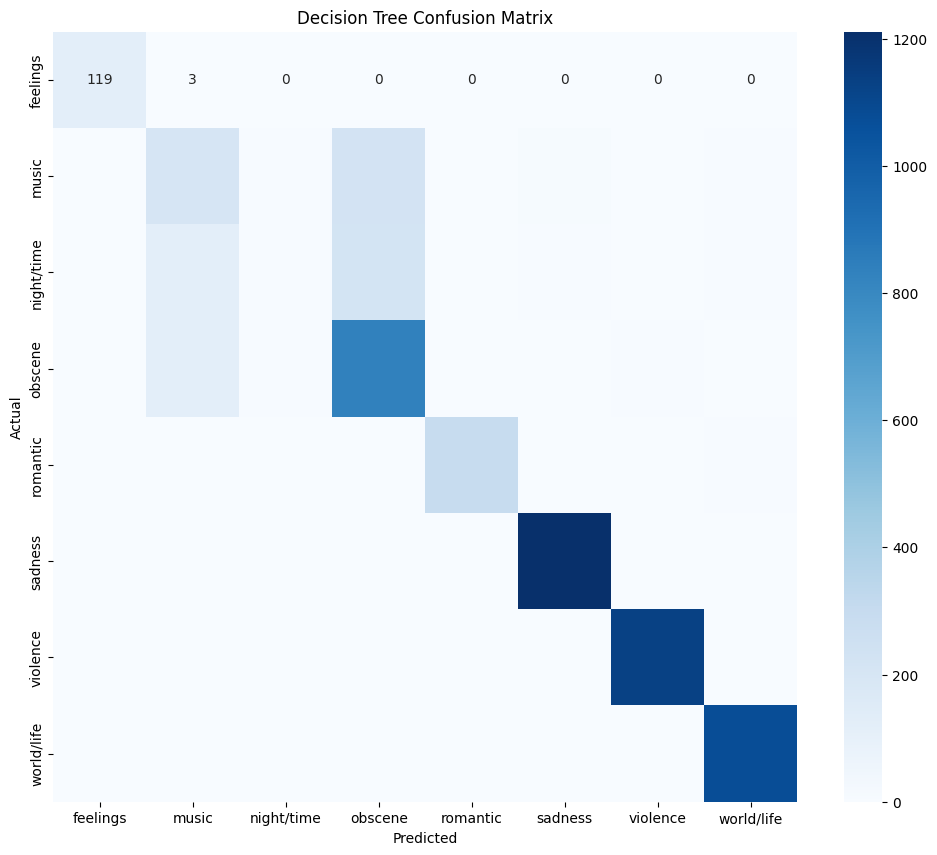

In [77]:
# Predict on the test set
y_pred = dt_clf.predict(X_test)

# Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_topic.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le_topic.classes_, yticklabels=le_topic.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()


In [80]:
# Train a new Decision Tree model with combined features
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Ensure 'topic' is categorical
data['topic'] = data['topic'].astype(str)
topic_le = LabelEncoder()
data['topic_encoded'] = topic_le.fit_transform(data['topic'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_combined, data['topic_encoded'], test_size=0.2, random_state=42)

# Train the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_clf.fit(X_train, y_train)

def get_mood_based_recommendations(desired_mood, data, dt_model, n_recommendations=5):
    if desired_mood not in topic_le.classes_:
        print(f"Mood '{desired_mood}' not recognized. Available moods: {list(topic_le.classes_)}")
        return []
    
    desired_mood_encoded = topic_le.transform([desired_mood])[0]
    mood_songs = data[data['topic_encoded'] == desired_mood_encoded]
    
    recommendations = mood_songs.sample(n=min(n_recommendations, len(mood_songs)))
    recommended_songs = recommendations[['track_name', 'artist_name', 'genre', 'topic']].to_dict('records')
    return recommended_songs

# Example: Recommend 5 'sadness' mood songs
desired_mood = 'sadness'
mood_recs = get_mood_based_recommendations(desired_mood, data, dt_clf, n_recommendations=5)

print(f"\nMood-Based Recommendations for '{desired_mood}':")
for rec in mood_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Topic: {rec['topic']})")


Mood-Based Recommendations for 'sadness':
- rainin' in my heart by slim harpo (Genre: blues, Topic: sadness)
- jah jah is the ruler by garnett silk (Genre: reggae, Topic: sadness)
- all the blacks by the original squad (Genre: hip hop, Topic: sadness)
- the crying clown by peter frampton (Genre: country, Topic: sadness)
- near wild heaven by r.e.m. (Genre: pop, Topic: sadness)


## 10. Genre Classfication Naive Bayes (part III)

In [81]:
# Already encoded 'genre_encoded' in previous steps
X_genre = data[numerical_features + ['topic_encoded']].values
y_genre = data['genre_encoded'].values

# Split into train and test
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_genre, y_genre, test_size=0.2, random_state=42, stratify=y_genre
)

print(f"Training samples: {X_train_g.shape[0]}")
print(f"Testing samples: {X_test_g.shape[0]}")


Training samples: 22697
Testing samples: 5675


In [82]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model
gnb.fit(X_train_g, y_train_g)


GaussianNB()

#### Evaluate

Naive Bayes Classification Report:
              precision    recall  f1-score   support

       blues       0.32      0.11      0.17       921
     country       0.34      0.62      0.44      1089
     hip hop       0.14      0.76      0.24       181
        jazz       0.43      0.29      0.35       769
         pop       0.36      0.11      0.17      1408
      reggae       0.39      0.34      0.36       500
        rock       0.35      0.43      0.39       807

    accuracy                           0.32      5675
   macro avg       0.33      0.38      0.30      5675
weighted avg       0.35      0.32      0.30      5675



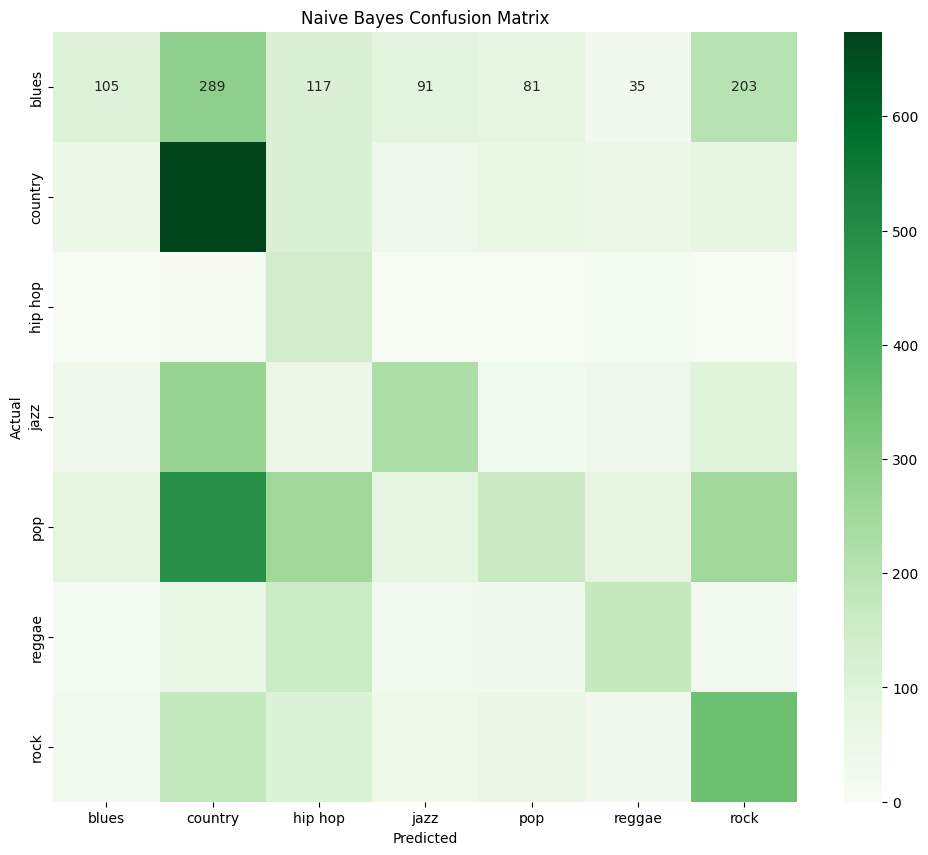

In [83]:
# Predict on the test set
y_pred_g = gnb.predict(X_test_g)

# Classification Report
print("Naive Bayes Classification Report:")
print(classification_report(y_test_g, y_pred_g, target_names=le_genre.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test_g, y_pred_g), annot=True, fmt='d',
            xticklabels=le_genre.classes_, yticklabels=le_genre.classes_, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


In [85]:
def get_genre_based_recommendations(desired_genre, data, nb_model, le_genre, n_recommendations=5):
    """
    Recommend songs based on a desired genre.
    
    Parameters:
    - desired_genre (str): The genre to filter songs.
    - data (DataFrame): The song dataset.
    - nb_model: Trained Naive Bayes model.
    - le_genre: LabelEncoder for genres.
    - n_recommendations (int): Number of recommendations to return.
    
    Returns:
    - List of recommended songs.
    """
    # Check if desired_genre exists
    if desired_genre not in le_genre.classes_:
        print(f"Genre '{desired_genre}' not recognized. Available genres: {list(le_genre.classes_)}")
        return []
    
    # Filter songs by desired genre
    desired_genre_encoded = le_genre.transform([desired_genre])[0]
    genre_songs = data[data['genre_encoded'] == desired_genre_encoded]
    
    # Sample songs
    recommendations = genre_songs.sample(n=min(n_recommendations, len(genre_songs)))
    
    # Prepare the list of recommendations
    recommended_songs = recommendations[['track_name', 'artist_name', 'genre', 'topic']].to_dict('records')
    return recommended_songs




#### Test

In [86]:
# Example: Recommend 5 'pop' genre songs
desired_genre = 'pop'
genre_recs = get_genre_based_recommendations(desired_genre, data, gnb, le_genre, n_recommendations=5)

print(f"\nGenre-Based Recommendations for '{desired_genre}':")
for rec in genre_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Topic: {rec['topic']})")


Genre-Based Recommendations for 'pop':
- youth by troye sivan (Genre: pop, Topic: violence)
- well...all right by buddy holly (Genre: pop, Topic: night/time)
- bread and roses by judy collins (Genre: pop, Topic: world/life)
- superstar by ms. lauryn hill (Genre: pop, Topic: obscene)
- feeling good by michael bublé (Genre: pop, Topic: feelings)


## 11. Simple Matrix Factorization for Collaborative Filtering (part IV)


In [87]:
from sklearn.preprocessing import LabelEncoder

# Assuming listening_history_df is already created and populated
# Encode User IDs and Song IDs
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()

listening_history_df['UserID_encoded'] = user_encoder.fit_transform(listening_history_df['UserID'])
listening_history_df['SongID_encoded'] = song_encoder.fit_transform(listening_history_df['SongID'])

# Create pivot table
user_item_matrix = listening_history_df.pivot_table(
    index='UserID_encoded',
    columns='SongID_encoded',
    values='Rating',
    aggfunc='mean'  # Use mean rating if multiple interactions
).fillna(0)

print("User-Item Matrix Shape:", user_item_matrix.shape)
print("Number of Users:", user_item_matrix.shape[0])
print("Number of Songs:", user_item_matrix.shape[1])


User-Item Matrix Shape: (1000, 23200)
Number of Users: 1000
Number of Songs: 23200


In [88]:
from sklearn.decomposition import TruncatedSVD

# Define the number of latent factors
n_factors = 50

# Initialize SVD
svd = TruncatedSVD(n_components=n_factors, random_state=42)

# Fit SVD on the user-item matrix
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T  # Items in latent space

print("User Factors Shape:", user_factors.shape)
print("Item Factors Shape:", item_factors.shape)


User Factors Shape: (1000, 50)
Item Factors Shape: (23200, 50)


In [89]:
def svd_recommendations(user_id, user_item_matrix, user_factors, item_factors, song_encoder, data, n_recommendations=5):
    """
    Recommend songs to a user based on SVD factorization.
    
    Parameters:
    - user_id (str): The user's original ID.
    - user_item_matrix (DataFrame): The user-item interaction matrix.
    - user_factors (ndarray): Latent factors for users.
    - item_factors (ndarray): Latent factors for items.
    - song_encoder (LabelEncoder): Encoder for song IDs.
    - data (DataFrame): The song dataset.
    - n_recommendations (int): Number of recommendations.
    
    Returns:
    - List of recommended songs.
    """
    # Encode user ID
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except ValueError:
        print(f"User ID '{user_id}' not found.")
        return []
    
    # Compute predicted ratings
    user_vector = user_factors[user_idx]
    predicted_ratings = np.dot(user_vector, item_factors.T)
    
    # Get songs the user has already interacted with
    user_songs = set(user_item_matrix.loc[user_idx][user_item_matrix.loc[user_idx] > 0].index)
    
    # Get song indices sorted by predicted rating
    sorted_song_indices = np.argsort(predicted_ratings)[::-1]
    
    # Recommend top songs not already interacted with
    recommendations = []
    for song_idx in sorted_song_indices:
        if song_idx not in user_songs:
            song_name = song_encoder.inverse_transform([song_idx])[0]
            song_data = data[data['track_name'] == song_name]
            if not song_data.empty:
                rec = song_data.iloc[0]
                recommendations.append({
                    'track_name': rec['track_name'],
                    'artist_name': rec['artist_name'],
                    'genre': rec['genre'],
                    'predicted_rating': predicted_ratings[song_idx]
                })
            if len(recommendations) >= n_recommendations:
                break
    
    return recommendations


In [90]:
# Example: Recommend 5 songs for a specific user
test_user_id = users_df['User_id'].iloc[0]
svd_recs = svd_recommendations(test_user_id, user_item_matrix, user_factors, item_factors, song_encoder, data, n_recommendations=5)

print(f"\nSVD-Based Recommendations for User ID '{test_user_id}':")
for rec in svd_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Predicted Rating: {rec['predicted_rating']:.2f})")



SVD-Based Recommendations for User ID '12-685-2499':
- all the things you are by dion & the belmonts (Genre: pop, Predicted Rating: 0.34)
- summertime by my chemical romance (Genre: pop, Predicted Rating: 0.28)
- let there be love by sammy davis jr. (Genre: jazz, Predicted Rating: 0.27)
- love is here to stay by billie holiday (Genre: blues, Predicted Rating: 0.26)
- winter wonderland by johnny mathis (Genre: pop, Predicted Rating: 0.25)


#### Evaluate

In [98]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split listening history into train and test
train_data, test_data = train_test_split(listening_history_df, test_size=0.2, random_state=42)


train_matrix = train_data.pivot_table(
    index='UserID_encoded',
    columns='SongID_encoded',
    values='Rating',
    aggfunc='mean'
).fillna(0)

test_matrix = test_data.pivot_table(
    index='UserID_encoded',
    columns='SongID_encoded',
    values='Rating',
    aggfunc='mean'
).fillna(0)


# Align test matrix with train matrix
test_matrix_aligned = test_matrix.reindex(columns=train_matrix.columns, fill_value=0)

# Reduce number of components 
n_factors = 45

# Fit SVD with fewer components
svd_train = TruncatedSVD(n_components=n_factors, random_state=42)
user_factors_train = svd_train.fit_transform(train_matrix)
item_factors_train = svd_train.components_.T

# Predict and evaluate
user_factors_test = svd_train.transform(test_matrix_aligned)
predicted_ratings = np.dot(user_factors_test, item_factors_train.T)

# Calculate both training and test RMSE to check for overfitting
train_predictions = np.dot(user_factors_train, item_factors_train.T)
train_rmse = sqrt(mean_squared_error(train_matrix.values.flatten(), train_predictions.flatten()))
test_rmse = sqrt(mean_squared_error(test_matrix_aligned.values.flatten(), predicted_ratings.flatten()))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Difference (Train-Test): {abs(train_rmse - test_rmse):.4f}")

Training RMSE: 0.2075
Test RMSE: 0.1084
Difference (Train-Test): 0.0991
